# Mounting drive



In [6]:
from google.colab import drive
from sys import path

drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/nlp-lab/'
path.append(root)

amazon_en_label = 'amazon_en'
amazon_de_label = 'amazon_de'
organic_label = 'organic'

data_location = 'data/data-with-embeddings/not-contextualized-embeddings/BERT-base-multilingual-cased/'
embedding_dim = 768

Mounted at /content/drive


In [48]:
import numpy as np
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import pandas as pd

import random
import copy
import json 

import torch
import torch.nn as nn
import torch.utils as utils
from torch import optim

from models.milnet import dataset, model, trainer, helpers

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
amazon_en_df, amazon_en_test_df = helpers.read_data(amazon_en_label,
                                                    ['train', 'test'],
                                                    root + data_location)

In [9]:
amazon_de_df, = helpers.read_data(amazon_de_label, ['all'],
                                  root + data_location)

In [5]:
organic_df, organic_test_df = helpers.read_data(organic_label,
                                                ['train', 'test'],
                                                root + data_location)

In [11]:
drop_neutral = False

if drop_neutral:
  print('======DROPPING NEUTRAL CLASS======')
  print('amazon_en: train')
  amazon_en_train_df = drop(amazon_en_train_df, 'comment_sentiment', '0')
  print('amazon_en: test')
  amazon_en_test_df = drop(amazon_en_test_df, 'comment_sentiment', '0')
  print('amazon_de')
  amazon_de_df = drop(amazon_de_df, 'comment_sentiment', '0')
  print('organic: train')
  organic_train_df = drop(organic_train_df, 'sentence_sentiment', '0')
  print('organic: test')
  organic_test_df = drop(organic_test_df, 'sentence_sentiment', '0')

if drop_neutral:
  sentiment_classes = {'n': 0, 'p': 1}
  sentiment_labels = {0 : 'n', 1 : 'p'} 
else:
  sentiment_classes = {'n': 0, '0': 1, 'p': 2}
  sentiment_labels = {0 : 'n', 1 : '0', 2 : 'p'} 

last_column = str(embedding_dim - 1)

In [17]:
test_size = 0.15 / (0.15 + 0.7)
amazon_en_train_df, amazon_en_val_df = helpers.split(amazon_en_df, test_size)
organic_train_df, organic_val_df = helpers.split(organic_df, test_size)

In [18]:
parse_params = (sentiment_classes, last_column, device)

In [21]:
amazon_en_train_dataset = helpers.parse_amazon_data(amazon_en_train_df,
                                                    *parse_params, 0.8, 0.8)
amazon_en_val_dataset = helpers.parse_amazon_data(amazon_en_val_df,
                                                  *parse_params)
amazon_en_test_dataset = helpers.parse_amazon_data(amazon_en_test_df,
                                                   *parse_params)

down: 9889, up negative: 1089, up neutral: 1199
down: 0, up negative: 0, up neutral: 0
down: 0, up negative: 0, up neutral: 0


In [23]:
amazon_de_test_dataset = helpers.parse_amazon_data(amazon_de_df, *parse_params)

down: 0, up negative: 0, up neutral: 0


In [24]:
organic_train_dataset = helpers.parse_organic_data(organic_train_df,
                                                   *parse_params)
organic_val_dataset = helpers.parse_organic_data(organic_val_df, *parse_params)
organic_test_dataset = helpers.parse_organic_data(organic_test_df,
                                                  *parse_params)
  

In [25]:
datasets = {amazon_en_label : amazon_en_train_dataset,
            amazon_de_label: amazon_de_test_dataset,
            organic_label: organic_train_dataset}

for label, dset in datasets.items():
  print(f'len({label}) = {len(dset)}')

len(amazon_en) = 7602
len(amazon_de) = 9897
len(organic) = 3558


In [28]:
prepare_batch = lambda batch: trainer.prepare_batch(batch, device)

params = model.MilNetParams()

params.seg_emb_dim =  embedding_dim
params.seg_hidden_dim = 300
params.hidden_dim = 50
params.gru_layers = 10
params.attention_dim = 100
params.dropout_gru = 0.8
params.dropout_att = 0.8
params.dropout_seg = 0.8
params.classes_nb = 3 - drop_neutral

In [35]:
optim_params = {'lr': 1\5e-3, 'weight_decay': 5e-2}
fit_params = {'nb_epochs': 50, 'patience': 50, 'print_every': 15}

milnet = model.MilNet(params, train_embeddings=False).to(device)

print("=====TRAIN ON AMAZON DATA=====")
_, amazon_train_losses, amazon_val_losses = helpers.train(milnet,
                                                          amazon_en_train_dataset,
                                                          amazon_en_val_dataset,
                                                          prepare_batch,
                                                          batch_size=32,
                                                          optim_params=optim_params,
                                                          fit_params=fit_params)

torch.save(milnet.state_dict(),
           root + f'/models/milnet/state_dicts/bert_ml_no_finetune_{params.classes_nb}cl_test')

# print("=====FINETUNE ON ORGANIC DATA=====")
# _, organic_train_losses, organic_val_losses = train(milnet, organic_train_dataset,
#                                                     organic_val_dataset,
#                                                     batch_size=128,
#                                                     optim_params=optim_params,
#                                                     fit_params=fit_params)
# torch.save(milnet.state_dict(),
#            root + f'/models/milnet/state_dicts/bert_ml_{params.classes_nb}cl')

=====TRAIN ON AMAZON DATA=====
Epoch  15/50 -> train loss: 3.21e-02, accuracy: 47.83%
Epoch  15/50 -> val loss: 3.11e-02, accuracy: 54.59%
Epoch  30/50 -> train loss: 3.18e-02, accuracy: 49.53%
Epoch  30/50 -> val loss: 3.19e-02, accuracy: 50.48%
Epoch  45/50 -> train loss: 3.15e-02, accuracy: 50.00%
Epoch  45/50 -> val loss: 3.12e-02, accuracy: 53.29%


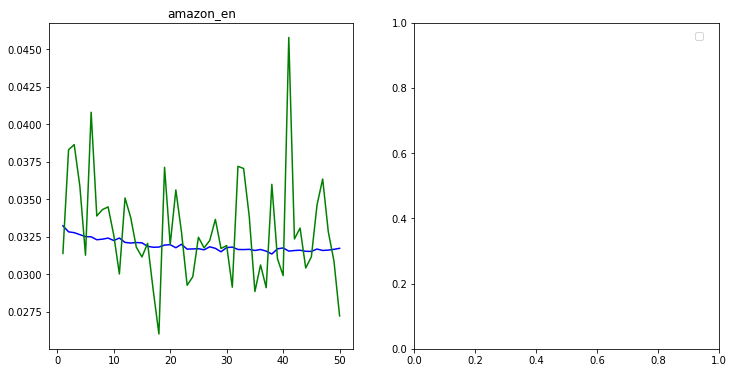

In [36]:
import matplotlib.pyplot as plt

def plot_losses(title, ax, train_losses, val_losses):
  epochs = np.arange(1, len(train_losses) + 1)
  ax.set_title(title)
  ax.plot(epochs, train_losses, color='blue', label='train')
  ax.plot(epochs, val_losses, color='green', label='validation')


fig, (ax_amazon, ax_organic) = plt.subplots(1, 2, figsize=(12,6))
plot_losses("amazon_en", ax_amazon, amazon_train_losses,
            amazon_val_losses)
# plot_losses("organic", ax_organic, organic_train_losses, organic_val_losses)

handles, labels = ax_organic.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.82, 0.8))

fig.show()

In [ ]:
milnet = model.MilNet(params, train_embeddings=False).to(device)
milnet.load_state_dict(torch.load(root + f'/models/milnet/state_dicts/bert_ml_no_finetune_{params.classes_nb}cl_test'))

<All keys matched successfully>

In [49]:
test_sets_dict = {'amazon_en': amazon_en_test_dataset,
                 'amazon_de': amazon_de_test_dataset,
                 'organic': organic_test_dataset}

results = helpers.get_results(milnet, test_sets_dict, prepare_batch)
helpers.print_results(results, sentiment_labels)

=== amazon_en ===
F1-micro = 0.709501797637391
F1-macro = 0.4248237736662359

           n     0     p
     n   270    99   558
     0   182   174   643
     p   843   503  6463

=== amazon_de ===
F1-micro = 0.554612508841063
F1-macro = 0.45300818191864156

           n     0     p
     n  2924   168  1050
     0  1201   158   674
     p  1162   153  2407

=== organic ===
F1-micro = 0.3931847968545216
F1-macro = 0.3770787010343702

           n     0     p
     n   108    37    74
     0   107    41   173
     p    42    30   151

